# AST 384C - Computational Astrophysics - HW 3
## Carlos Jurado

In [2]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import scipy.spatial 
from pyro import Pyro
from numba import njit, prange

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1: using KTrees

Set up a code that can generate (uniform) random postions in 3D for a set of N equal-mass
particles in the range [0, 100] in each dimesion. Make sure to use a random number
generator with a seed state that you can specify so that these initial positions are repeatable
exactly.
calculate the acceleration of every particle assuming vacuum boundary conditions (i.e., you
don’t have to worry about periodic boundaries or anything like that) both directly and
using a KDTree for N ∈103,4,5,6. How does the timing scale for each method? Do your
calculations depend on the method you used?

If we let $GM = 1$ in arbitrary units, then the acceleration felt by a particle at position, $r_i$, is given as:

$$ 
\vec{a_i} = \sum_{j=0}^{N} \left( \frac{-\vec{r_{ij}}}{|\vec{r_{ij}}|^3}\right), i \neq j
$$

#### Initially, I wrote my direct and KDtree method of calculating the acceleration of the particles using nested for-loops. By 10^4 particles, the code had been very inefficient. I have since restructured my code to be vectorized and it has improved the computational speeds up to 10^4 particles. I am still having difficulty running the code for the 10^5 particle case. The following cell contains my revisions for the fully vectorized implementation for calculating the accelerations. 

#### To boost computational speed even further, I decided to implement Numba, which compiles my python code into C before running. This implementation is contained below the section titled. Numba Implementation For Calculating Accelerations of Particles

## Fully Vectorized Implementation For Calculating Accelerations of Particles

In [3]:
'''
np.random.seed(1234) #initalize random seed for reproducibility

N_arr = [10**3, 10**4, 10**5]


#i - represents an individual particle 
#j - represents a pair interaction on the ith particle 

for N in N_arr:

    #Create the numpy array structure to hold the position (acceleration) vectors for all particles
    r_vecs, acceleration_vecs = np.random.uniform(0,100,size=(N, 3)), np.zeros((N, 3)) 
    #print(r_vecs.shape)
    # Create the numpy array structure to hold the displacement (magnitudes) for all particles from one another
    displacement_vecs,  distances = np.zeros((N, N, 3)), np.zeros((N, N))    
    #print(displacement_vecs.shape)

    start_time = time.time()
    
    ###for i in range(N): #loop through each particle
        ###for j in range(N): #loop through each interaction acting on a given particle

            #Calculate the displacement between a particle and one of the other particles
            ###displacement_vecs[i,j] = r_vecs[j] - r_vecs[i] 

            #compute the distance from the displacement vector
            ###distances[i,j] = np.sqrt(displacement_vecs[i,j,0]**2 + displacement_vecs[i,j,1]**2 + displacement_vecs[i,j,2]**2) 

    displacement_vecs = r_vecs[:, np.newaxis, :] - r_vecs[np.newaxis, :, :]
    distances = np.linalg.norm(displacement_vecs, axis=2)

    #ignore the self-interaction term
    ###mask = distances[i] > 0
    #calculate the sum of the accelerations on one particle due to all of the other particles
    ###acceleration_vecs[i] = np.sum( displacement_vecs[i][mask] * (1.0 / distances[i][mask]**3)[:, np.newaxis], axis=0 ) 

    mask = distances > 0 
    distances_nonzero = np.where(mask, distances, 1)  # Replace zeros with 1 to avoid division by zero
    acceleration_vecs = np.sum(displacement_vecs * ((1.0 / distances_nonzero**3) * mask)[:, :, np.newaxis], axis=1)
    end_time = time.time()

    print(f"Directly: The time taken to setup {N} particles is {np.round(end_time - start_time,2)} seconds")
'''

'''

    ###Below is the KD Tree Implementation 
    start_time = time.time() 
    acceleration_vecs_KD = np.zeros((N, 3))
    displacement_vecs_KD, distances_KD = np.zeros((N, N, 3)), np.zeros((N, N))

    my_KD = scipy.spatial.cKDTree(r_vecs) #initalize my KD tree
    for i in range(N):
        # calculate the distance of the nearest neighbor for the N nearests neighbors. In other words, I am getting back 
        # a ascending ordered list of distances for particle pairings on the ith particle
        distances_KD[i], indices = my_KD.query(r_vecs[i], k=N) 

        ###for j in range(N):
            #Calculate the displacement vectors between a particle and all other particles 
            ###displacement_vecs_KD[i,j] = r_vecs[j] - r_vecs[i]    
    displacement_vecs_KD = r_vecs[:, np.newaxis, :] - r_vecs[np.newaxis, :, :]


        ###mask = distances_KD[i] > 0 #ignore the self-interaction term
    mask = distances_KD > 0 

        #calculate the sum of the accelerations on one particle due to all of the other particles
        ###acceleration_vecs[i] = np.sum( displacement_vecs_KD[i][mask] * (1.0 / distances_KD[i][mask]**3)[:, np.newaxis], axis=0 ) 
    distances_nonzero = np.where(mask, distances_KD, 1)  # Avoid division by zero
    acceleration_vecs_KD = np.sum(displacement_vecs_KD * ((1.0 / distances_nonzero**3) * mask)[:, :, np.newaxis], axis=1)

    end_time = time.time()

    print(f"KD Tree: The time taken to setup {N} particles is {np.round(end_time - start_time,2)} seconds")

    print('=====================NEW ITERATION==========================')
'''






'\n\n    ###Below is the KD Tree Implementation \n    start_time = time.time() \n    acceleration_vecs_KD = np.zeros((N, 3))\n    displacement_vecs_KD, distances_KD = np.zeros((N, N, 3)), np.zeros((N, N))\n\n    my_KD = scipy.spatial.cKDTree(r_vecs) #initalize my KD tree\n    for i in range(N):\n        # calculate the distance of the nearest neighbor for the N nearests neighbors. In other words, I am getting back \n        # a ascending ordered list of distances for particle pairings on the ith particle\n        distances_KD[i], indices = my_KD.query(r_vecs[i], k=N) \n\n        ###for j in range(N):\n            #Calculate the displacement vectors between a particle and all other particles \n            ###displacement_vecs_KD[i,j] = r_vecs[j] - r_vecs[i]    \n    displacement_vecs_KD = r_vecs[:, np.newaxis, :] - r_vecs[np.newaxis, :, :]\n\n\n        ###mask = distances_KD[i] > 0 #ignore the self-interaction term\n    mask = distances_KD > 0 \n\n        #calculate the sum of the accel

## Numba Implementation For Calculating Accelerations of Particles

In [4]:
N_arr = [50, 10**2, 10**3, 10**4, 10**5]
time_direct_arr = []
time_KD_arr = []

@njit(parallel=True)
def compute_accelerations(r_vecs, indices=None, distances=None):
    ''' 
    Computes the acceleration of all particles due to the gravitational force from every other particle in the simulation. 
    The acceleration is computed for the direct method. 

    Parameters:
    r_vecs: Numpy array (N, 3) containing the position vector of all particles 
    indices: (For KD Tree Impementation) Index of a particle. In this context, this is an array of the indices for the nearest neighbors to the given particle 
    distances: (For KD Tree Impementation)
    '''
    N = r_vecs.shape[0]
    acc = np.zeros((N, 3))
    
    #Direct Method calculation of the accelerations
    if indices is None:
        for i in prange(N): #loop through each particle
            for j in range(N): #loop through each interaction acting on a given particle
                if i != j: #avoid self-interaction
                    dx = r_vecs[j, 0] - r_vecs[i, 0] #calculate displacement in x-direction
                    dy = r_vecs[j, 1] - r_vecs[i, 1] #calculate displacement in y-direction
                    dz = r_vecs[j, 2] - r_vecs[i, 2] #calculate displacement in z-direction
                    squared_distance = dx*dx + dy*dy + dz*dz  #compute the distance
                    Fg = 1.0 / ((squared_distance)**3 + 1e-6) #calculate the gravitational force
                    acc[i, 0] += dx * Fg #multiply x-acceleration by the x-vector component 
                    acc[i, 1] += dy * Fg #multiply y-acceleration by the y-vector component 
                    acc[i, 2] += dz * Fg #multiply z-acceleration by the z-vector component 
    return acc


'''
@njit(parallel=True)
def compute_accelerations_KDE(r_vecs, indices, distances):
     
    #Computes the acceleration of all particles due to the gravitational force from every other particle in the simulation. 
    #The acceleration is computed for the KDTree method. 

    #Parameters:
    #r_vecs: Numpy array (N, 3) containing the position vector of all particles 
    #indices: (For KD Tree Impementation) Index of a particle. In this context, this is an array of the indices for the nearest neighbors to the given particle 
    #distances: (For KD Tree Impementation)
    
    N = r_vecs.shape[0]
    acc = np.zeros((N, 3))
    #KD Tree Method calculation of the accelerations
    K = indices.shape[1]
    for i in prange(N): #loop through each particle
        for k in range(K): #loop through each interaction acting on a given particle (maximum of 10% nearest neighbors)
            j = indices[i, k]
            if i != j: #avoid self-interaction
                dx = r_vecs[j, 0] - r_vecs[i, 0] #calculate displacement in x-direction
                dy = r_vecs[j, 1] - r_vecs[i, 1] #calculate displacement in y-direction
                dz = r_vecs[j, 2] - r_vecs[i, 2] #calculate displacement in z-direction
                dist = distances[i, k]
                Fg = 1.0 / (dist**3 + 1e-6)
                acc[i, 0] += dx * Fg
                acc[i, 1] += dy * Fg
                acc[i, 2] += dz * Fg
                  
    return acc
'''

def compute_accelerations_ball(r_vecs, neighbors_list):
    N = r_vecs.shape[0]
    acc = np.zeros((N, 3))
    for i in range(N):
        for j in neighbors_list[i]:
            if i != j:
                dx = r_vecs[j, 0] - r_vecs[i, 0]
                dy = r_vecs[j, 1] - r_vecs[i, 1]
                dz = r_vecs[j, 2] - r_vecs[i, 2]
                squared_distance = dx*dx + dy*dy + dz*dz
                Fg = 1.0 / ((squared_distance)**1.5 + 1e-6)
                acc[i, 0] += dx * Fg
                acc[i, 1] += dy * Fg
                acc[i, 2] += dz * Fg
    return acc


for N in N_arr: #loop through simulations with different number of particles
    print(f"\nN = {N}")
    
    # Direct Method
    r_vecs = np.random.uniform(0, 100, size=(N, 3)) #generate uniform random distribution of particles in 3D space
    
    start_time = time.time() #begin tracking time
    acceleration_vecs = compute_accelerations(r_vecs) #calculate the accelerations
    end_time = time.time()
    
    elapsed_time = np.round(end_time - start_time, 2)
    time_direct_arr.append(elapsed_time)
    print(f"Direct: Time taken for {N} particles: {elapsed_time} s")
    
    # KD Tree Method
    k = int(0.1 * N) # only use nearest 10% of the neighbors
    start_time = time.time()
    
    
    my_KD = scipy.spatial.cKDTree(r_vecs) #initialize KD Tree
    #distances_KD, indices_KD = my_KD.query(r_vecs, k=k)
    radius = 10.0
    neighbors_list = my_KD.query_ball_point(r_vecs, r=radius)

    #acceleration_vecs_KD = compute_accelerations_KDE(r_vecs, indices_KD, distances_KD)  #calculate the accelerations
    acceleration_vecs_KD = compute_accelerations_ball(r_vecs, neighbors_list)
    end_time = time.time() #end tracking time

    elapsed_time = np.round(end_time - start_time, 2)
    time_KD_arr.append(elapsed_time)
    print(f"KD Tree: Time taken for {N} particles: {elapsed_time} s")
    print("============================================================")



N = 50
Direct: Time taken for 50 particles: 1.32 s
KD Tree: Time taken for 50 particles: 0.0 s

N = 100
Direct: Time taken for 100 particles: 0.0 s
KD Tree: Time taken for 100 particles: 0.0 s

N = 1000
Direct: Time taken for 1000 particles: 0.0 s
KD Tree: Time taken for 1000 particles: 0.01 s

N = 10000
Direct: Time taken for 10000 particles: 0.09 s
KD Tree: Time taken for 10000 particles: 0.82 s

N = 100000
Direct: Time taken for 100000 particles: 13.25 s
KD Tree: Time taken for 100000 particles: 77.36 s


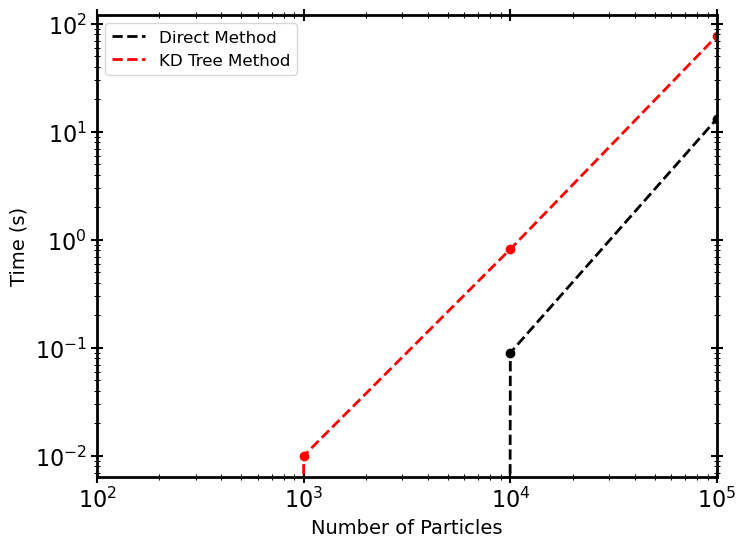

In [8]:
plt.scatter(N_arr, time_direct_arr, color='black')
plt.plot(N_arr, time_direct_arr, color='black', linestyle='--', lw=2, label='Direct Method')

plt.scatter(N_arr, time_KD_arr, color='red')
plt.plot(N_arr, time_KD_arr, color='red', linestyle='--', lw=2, label='KD Tree Method')

plt.xlabel('Number of Particles')
plt.ylabel('Time (s)')

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**2, 10**5)
plt.legend()

### How does the timing scale for each method? Do your calculations depend on the method you used?

#### I'll start off by saying I was unable to get a convergence for 10^6 particles within a reasonable timescale. At around the 40 minute mark, my kernel crashes and I am unsure how to work around this. I suspect there is an issue with how I'm sampling from the KD tree that is making this a O(N^2) time complexity when I expect ~ Nlog(N). The time scaling for each method is linear in log-log. Therefore each method scales following a power law. Surprisingly, the direct method is computationally faster than the KD tree method. 

# Problem 2: hydro solvers

Play around with it and have a look at the code – especially riemann.py, which will really
help you understand how the Riemann problem is implemented and solved.

• Run the Kelvin-Helmholtz tests for the 4 hydro solvers exactly as in the code guide.

• Now repeat this with a relative velocity of ±10 instead of 1. Describe the differences, if
any, and their origin, relative to the u =±1 case.
1


Simulation with gamma=1.7 and Delta U = 1 km/s using compressible.


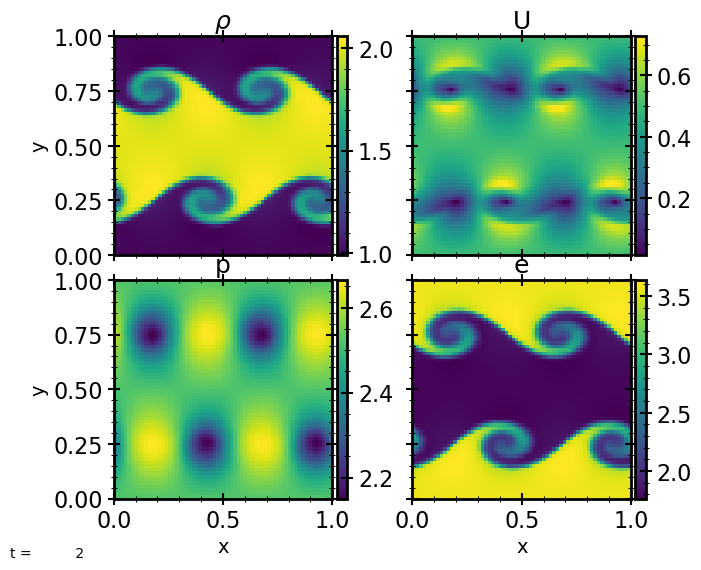

Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_rk.


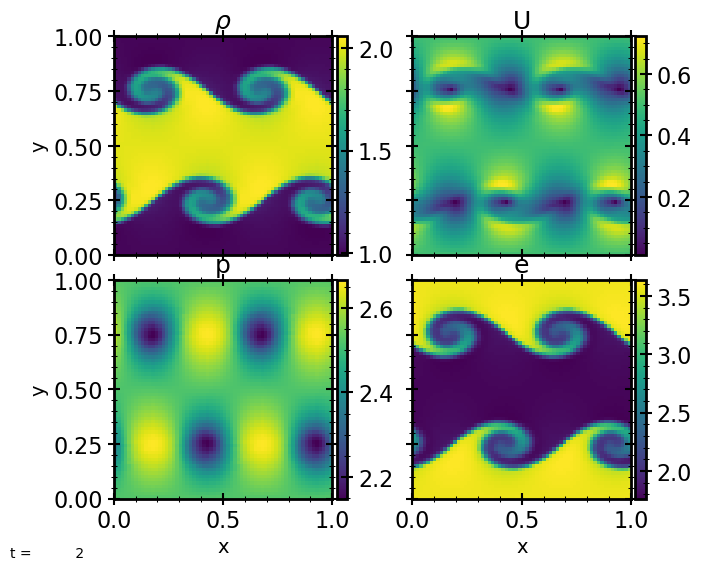

Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_fv4.


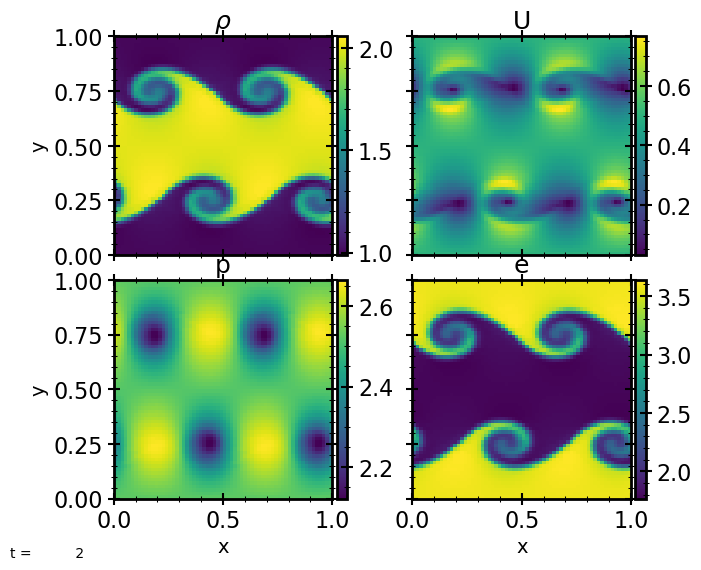

warning, key: compressible.limiter not defined
Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_sdc.


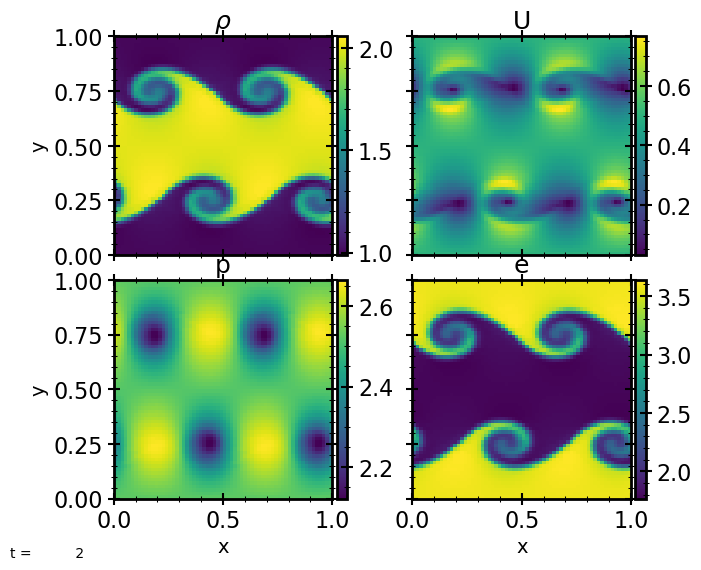

<Figure size 800x600 with 0 Axes>

In [6]:
first_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"] #list of the hydro solvers to use
first_problem_name = "kh"
first_param_file = "inputs.kh" #reference the input parameter file
first_extra_parameters = {'eos.gamma': 1.7, 'kh.bulk_velocity': 0,} #input parameters to change

for solver in first_solvers:
    pyro_sim = Pyro(solver) #create a Pyro object
    pyro_sim.initialize_problem(first_problem_name, inputs_file=first_param_file, inputs_dict=first_extra_parameters) #initalize a Pyro object with the input parameters
    #print(pyro_sim)
    pyro_sim.run_sim() #time evolve the simulation
    print(f"Simulation with gamma=1.7 and Delta U = 1 km/s using {solver}.")
    pyro_sim.sim.dovis() #plot the results

Simulation with gamma=1.7 and bulk velocity = 10 km/s using compressible.


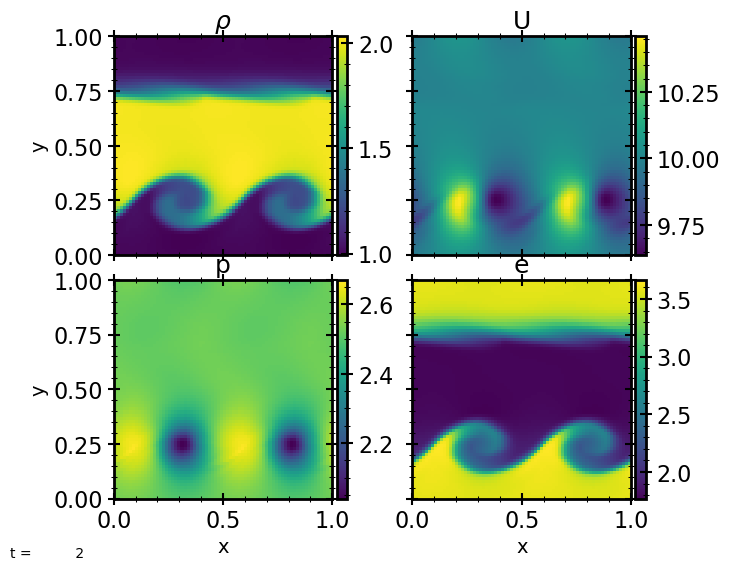

Simulation with gamma=1.7 and bulk velocity = 10 km/s using compressible_rk.


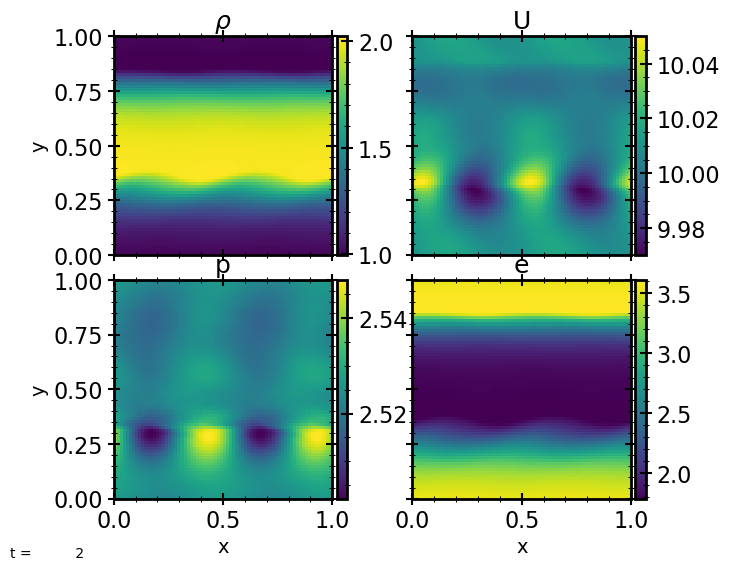

Simulation with gamma=1.7 and bulk velocity = 10 km/s using compressible_fv4.


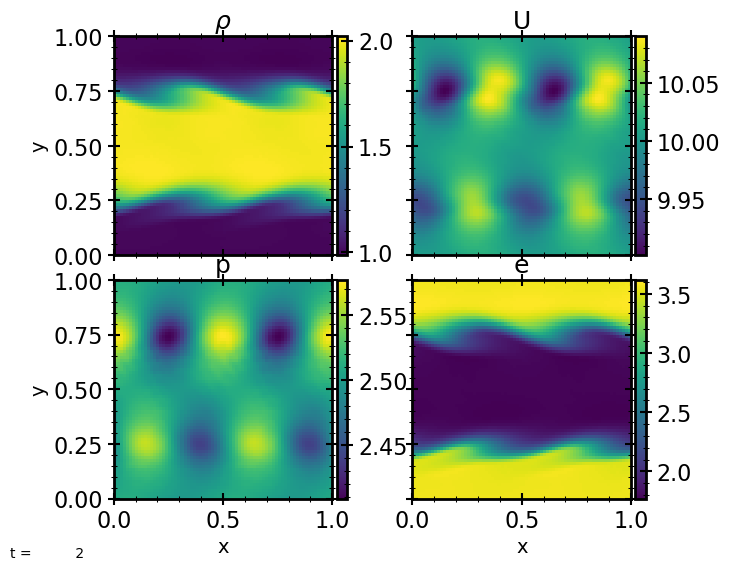

warning, key: compressible.limiter not defined
Simulation with gamma=1.7 and bulk velocity = 10 km/s using compressible_sdc.


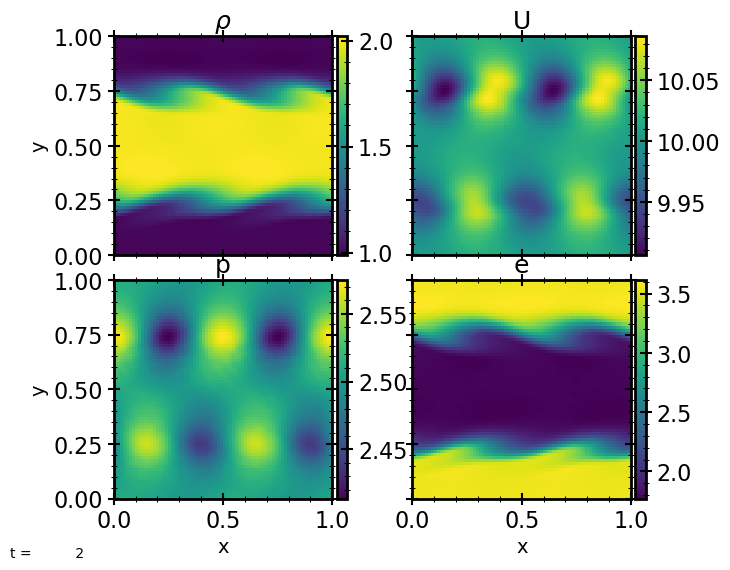

<Figure size 800x600 with 0 Axes>

In [7]:
second_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"]
second_problem_name = "kh"
second_param_file = "inputs.kh"
second_extra_parameters = {'eos.gamma': 1.7, 
                           'mesh.nx' : 72, 'mesh.ny' : 72,
                           'kh.bulk_velocity': 10,
                           'kh.u_1': -0.5, 'kh.u_2': 0.5}

for solver in second_solvers:
    pyro_sim = Pyro(solver) #create a Pyro object
    pyro_sim.initialize_problem(second_problem_name, inputs_file=second_param_file, inputs_dict=second_extra_parameters) #initalize a Pyro object with the input parameters
    pyro_sim.run_sim() #time evolve the simulation
    print(f"Simulation with gamma=1.7 and bulk velocity = 10 km/s using {solver}.")
    pyro_sim.sim.dovis() #plot the results

Simulation with gamma=1.7 and relative velocity = 5 km/s using compressible.


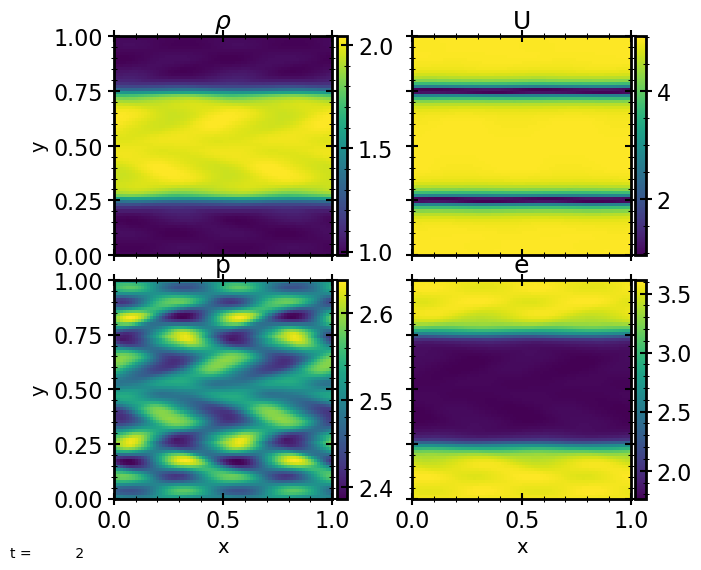

Simulation with gamma=1.7 and relative velocity = 5 km/s using compressible_rk.


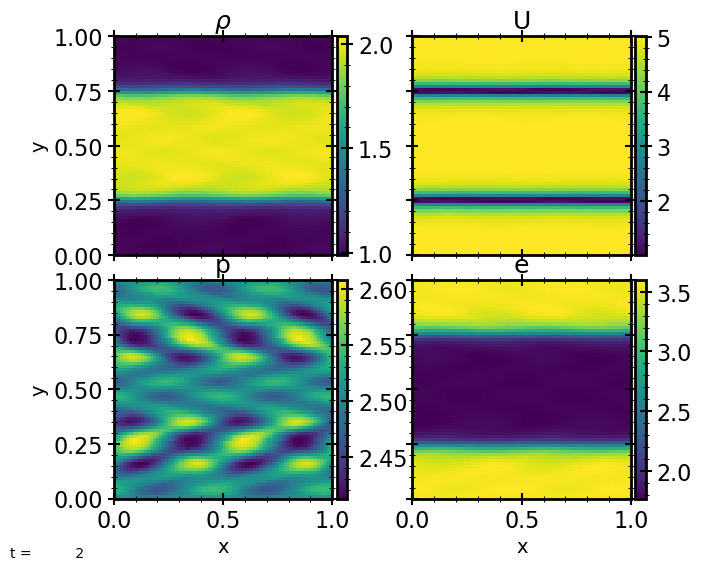

Simulation with gamma=1.7 and relative velocity = 5 km/s using compressible_fv4.


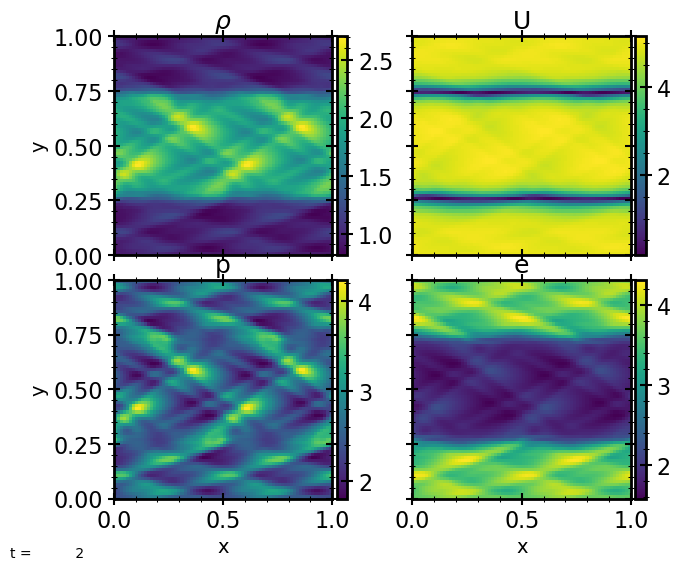

warning, key: compressible.limiter not defined
Simulation with gamma=1.7 and relative velocity = 5 km/s using compressible_sdc.


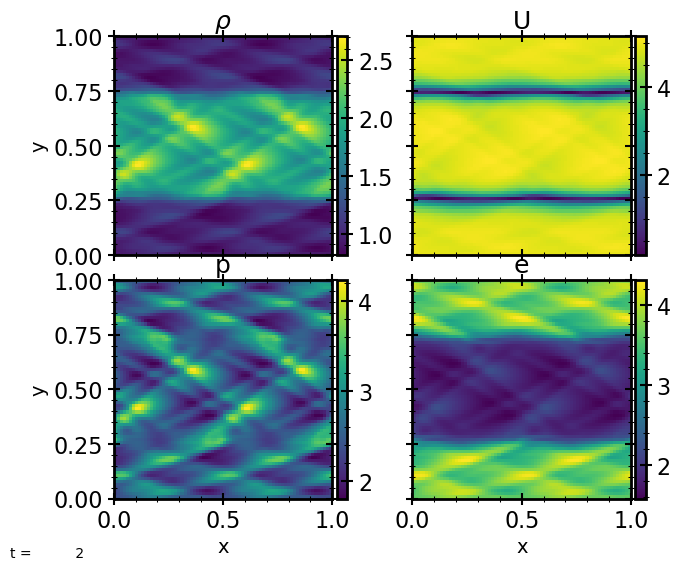

<Figure size 800x600 with 0 Axes>

In [12]:
second_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"]
second_problem_name = "kh"
second_param_file = "inputs.kh"
second_extra_parameters = {'eos.gamma': 1.7, 
                           'mesh.nx' : 72, 'mesh.ny' : 72,
                           'kh.bulk_velocity': 0,
                           'kh.u_1': -5, 'kh.u_2': 5}

for solver in second_solvers:
    pyro_sim = Pyro(solver) #create a Pyro object
    pyro_sim.initialize_problem(second_problem_name, inputs_file=second_param_file, inputs_dict=second_extra_parameters) #initalize a Pyro object with the input parameters
    pyro_sim.run_sim() #time evolve the simulation
    print(f"Simulation with gamma=1.7 and relative velocity = 5 km/s using {solver}.")
    pyro_sim.sim.dovis() #plot the results

Describe the differences, if any, and their origin, relative to the u =±1 case.

##### In the Delta U = 10 case, I notice that shapes of the upper left plot changes depending on the solver implementation. The 'compressible' and 'compressible_rk' solvers show different structure for the fluid motion then the 'compressible_fv4' and 'compressible_sdc' cases. I suspect that this is a numerical artifact as the only differences are how the hydro equations are being solved. At the same resolution, finer details are seen with the 'compressible_fv4' and 'compressible_sdc' solvers, including some fluid interactions occuring at the boundaries of the two fluids. This did not appear to be the issue with the delta u = 1 cases.